# Řešení obyčejných diferenciálních rovnic (ODR)

V této kapitole se seznámíme s řešením obyčejných diferenciálních rovnic (ODR) na počítači. Obecný tvar ODR *N-tého* řádu je následující:

$$
p(x, y, y^{\prime}, y^{\prime \prime}, \dots, y^{(n)}) = f(x, y(x)), \hspace{5pt} y^{(i)}(0) = y_0^i \hspace{5pt} \forall i \in [0, N-1],
$$

kde $y^{(i)}(0) = y_0^i$ je sada $n$ počátečních podmínek pro hodnoty jednotlivých derivací funkce $y$ v počátečním bodě $0$. Vidíme, že diferenciální rovnice není sama o sobě kompletní řešitelnou úlohou. Jelikož máme vztah obsahující derivace neznámé funkce, potřebujeme vždy znát nějaké okrajové nebo počáteční podmínky. Zde jsme představili případ, kdy známe počáteční hodnotu všech derivací funkce $y$ do stupně $n-1$ v **jednom bodě**. Taková úloha se nazývá *počáteční problém*. Druhým typem úlohy (*okrajový problém*), kdy podmínky nemusí být zadané pouze v jednom bodě, se budeme zabývat v posledním cvičení. 

Předchozí diferenciální rovnici lze vždy převést na soustavu $n$ obyčejných diferenciálních rovnic prvního řádu (viz přednáška):

$$
\frac{dy_i}{dx} = f(x, y_0, y_1, \dots, y_{n-1}), \hspace{5pt} y_i(0) = y_0^i \hspace{5pt} \forall i \in [0, N-1],
$$

nebo vektorově:

$$
\frac{d \vec{y}}{dx} = f(x, \vec{y}), \hspace{5pt} \vec{y}(0) = \vec{y}_0.
$$

Obyčejné diferenciální rovnice typicky popisují vývoj určitého dynamického systému (kde $x \equiv t$ je chápáno jako čas). Příkladem může být:
* exponenciální růst (populace): 

$$
\frac{dN}{dt} = r N
$$

* logistický růst (populace): 

$$
\frac{dN}{dt} = r_{max}\frac{K - N}{K} N
$$

![Růst populace](../images/growth.png)

* harmonický oscilátor: 

$$
m \ddot{x} = -k x
$$

* Keplerova úloha: 

$$
\ddot{\vec{r}} = -\frac{G M}{r^3} \vec{r}
$$

V předchozím cvičení jsme viděli, že integrování je speciálním případem řešení ODR s $f = f(x)$ a nulovou počáteční podmínkou. Skutečně řešení ODR můžeme chápat jako postupné přičítání příspěvků změny (derivace, která je daná funcí $f(x, y)$) hodnoty funkce $y(x)$. Výhoda metod řešících ODR spočívá v možnosti volby **adaptivního kroku** (tak jak je vyžadováno) v průběhu výpočtu, jak uvidíme zanedlouho.

Základní myšledka, jak ODR řešit na počítači, spočívá v nahražení diferenciálů $dy$ a $dx$ pomocí velmi malých, ale konečných příspěvků $\Delta y$ a $\Delta x$. Tím získáme *soustavu algebraických rovnic*, které již na počítači dokázeme efektivně řešit. Také uvidíme, že určení **chyby** výpočtu je analogické jako v případě integrace. Využije řešení získané stejnou metodou při odlišném kroku.

Existují tři hlavní typy metod pro řešení ODR:
* Runge-Kuttovy metody
* Bulirsch-Stoerova metoda
* Metody prediktor-korektor

Zde se zaměříme zejména na první dvě skupiny, jelikož jednodušší verze metod typu prediktor-korektor jsou exaktně stejné jako Runge-Kuttovy metody. Přesto, jako vždy, okomentujeme výhody a nevýhody různých metod. Jako vždy v numerice neexistuje jedna nejlepší metoda na všechny možné úlohy!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Pro testování různých metod použijeme následující úlohu (obdoba *vývoje populace*):

$$
\frac{dy(t)}{dt} = (1 + 2\cos{(t)}) y(t)
$$

U této diferenciální rovnice lze určit řešení analyticky: $\tilde{y}(t) = \exp(t + 2\sin{(t)}) \tilde{y}(0)$.

In [21]:
def f(t, y):
    return (1 + 2*np.cos(t)) * y

def y_sol(t):
    return np.exp(t + 2*np.sin(t)) 

# počáteční podmínka
y_0 = 1

# časový interval
T0 = 0
T = 5

## Runge-Kuttovy metody

Hlavní myšlenkou těchto metod je vývoj řešení (funkce $y$) pomocí lineární kombinace vnořených kroků jednoduché Eulerovy metody (následující sekce). Tato lineární kombinace je srovnána s *Taylorovým rozvojem* určitého řádu.

Obecný vzorec pro *explicitní metody* pro ODR N-tého řádu:

$$
y_{i+1} = y_i + h \sum_{j = 1}^{r} b_j k_j(h), \hspace{5pt} \forall i \in [0, N-1],
$$

kde 

$$
k_j = f(x_i + c_j h, y_i + h \sum_{l = 1}^{j-1} a_{jl} k_l)
$$

Koeficienty jsou získány srovnáním s Taylorovým rozvojem požadovaného řádu. Existuje mnoho kombinací hodnot koeficientů. Runge-Kuttovy metody se pak efektivně popisují *Butcherovou tabulkou*, ve které se vyskytují hodnoty všech koeficientů dané metody:

$$
\begin{array}
{c|cccc}
c_1 & a_{11} & 0 & \cdots & 0 \\
c_2 & a_{21} & a_{22} & \cdots & 0 \\
\vdots & \vdots & \vdots  & \ddots & \vdots \\
c_r & a_{r1} & a_{r2} & \cdots & a_{rr}\\
\hline
& b_1 & b_2 & \cdots & b_{r}
\end{array}
$$

Následující dvě metody odpovídají jednoduchému nahrazení derivace pomocí buď *dopředné* (Euler) nebo *centrální* diference (leap-frog). Přesto tyto metody spadají do obecné definice RK metod, a proto si je předstabujeme zde.

Dále se budeme věnovat pouze metodám pro řešení **ODR 1. řádu**. Vzorec pro RK metody je stejný, akorát $y$ je skalár.

Vlastnosti:
* velmi robustní pro nehladké funkce $f$, adaptivní krok $h$
* více výpočtů pravé strany $f$ -> nevýhodné pokud výpočetně náročné
* většinou nejrychlejší, bežně používané RK4 (RK45 - vnořená metoda)

### Eulerova metoda

Nejjednoduší možností, jak se vypořádat s derivací je nahrazení diferenciálů pomocí konečných rozdílů vzdálených konečným krokem $\Delta \equiv h$:

$$
\frac{dy}{dx} \approx \frac{y_{i+1} - y_{i}}{x_{i+1} - x_{i}} = f(x_i, y_i),
$$

kde $y_i = y(x_i)$. Tedy po úpravě dostáváme jednoduchý explicitní vzorec pro vývoj $y$:

$$
y_{n+1} = y_{n} + h f(x_n, y_n),
$$

s počáteční podmínkou $y(x_0) = y_0$.

![Eulerova metoda](../images/eulerRK.png)

Zvolíme počet kroků:

In [29]:
# pocet kroku
M = 100

# delka kroku
h = (T - T0) / M

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *Eulerovu metodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [43]:
def euler(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    err = 0
    t = T0
    for i in range(steps):
        ## DOPLŇTE ##
        y[i+1] = y[i] + h*f(t, y[i])
        t = t + h
        
        y2h = y[i] + 2*h*f(t, y[i])
        yh = y[i] + h*f(t, y[i]) + h*f(t+h, y[i+1])
        err += np.abs(yh - y2h) / 2
        
    
    return y, err

y_euler, err = euler(f, y_0, h, steps=M)

print('y_euler:', y_euler[-1], err)
print('y_sol:  ', y_sol(T))

y_euler: 17.567021635626023 3.544938762665188
y_sol:   21.805264918818242


Text(0.5, 0, '$t$')

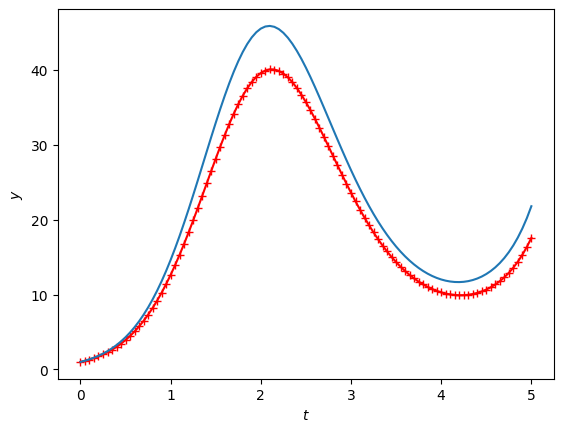

In [31]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_euler, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

**Odhad chyby metody**

Jak odhadnout chybu numeriké metody řešící ODR? Jako v předchozí kapitole využijeme znalosti řádu metody a druhého výpočtu s jiným krokem.

Při jednom kroku Eulerovy metody se dopouštíme chyby druhého řádu v $h$:

$$
\tilde{y}_{n+1} = y_{n} + h f(x_n, f_n) + \mathcal{O}(h^2) = y_{n+1} + a h^2 + \mathcal{O}(h^3) \equiv  y_{n+1} + \varepsilon(y_{n+1}).
$$

Chybu v jednom kroce lze odhadnout aplikováním Eulerovy metody s krokem $2h$ a $h$:
$$
\tilde{y}^{2h}_{n+2} = y^{2h}_{n+2} + a (2h)^2 + \mathcal{O}(h^3),
$$

a 

$$
\tilde{y}^{h}_{n+2} = y^{h}_{n+2} + 2a (h)^2 + \mathcal{O}(h^3),
$$

kde byly provedeny dva kroky o délce $h$ a $\tilde{y}$ je přesné řešení. Odečtením obou rovnic dostáváme (přesné řešení se rovnají):

$$
y^{h}_{n+2} - y^{2h}_{n+2} = 2ah^2 + \mathcal{O}(h^3),
$$

a tedy chybu odhadneme pomocí:

$$
\varepsilon(y_{n+1}) \approx \frac{y^{h}_{n+2} - y^{2h}_{n+2}}{2} = a h^2 + \mathcal{O}(h^3).
$$

Vidíme, že skutečně provádíme pouze **odhad**. Přesnou chybu nedokážeme určit, přesto nám tento odhad stačí. Víme totiž, že odchylka od reálné chyby je až vyššího řádu v $h$ (zde konkrétně $\sim h^3$).

Celkovou chybu určíme jako součet chyb v každém kroce.

In [46]:
y_euler_h = euler(f, y_0, h, M)
y_euler_2h = euler(f, y_0, 2*h, M//2)

chyba_euler = np.abs(y_euler_h[-1] - y_euler_2h[-1])

print('Odhad chyby: ', chyba_euler)
print('Realná chyba:', np.abs(y_euler[-1] - y_sol(T)))

Odhad chyby:  2.6304401290871313
Realná chyba: 4.238243283192219


### Metoda středního bodu (midpoint/leap-frog)


### Heunova metoda


### Runge-Kuttova metoda 4. řádu


### Implicitní Eulerova metoda

## Bulirsch-Stoerova metody


## Metody prediktor-korektor (vícekrokové metody)



## Runge-Kuttovy metody pro soustavu ODR (nD)

